In [275]:
using FileIO
using Plots
include("splitcell.jl")
include("segmentation3d.jl")
include("lineage.jl")
include("normalization3d.jl")
include("tiffxml.jl")

embedxml

In [2]:
@time d16s1 = load(File(format"TIFF", "../mRNA_confocal_hamamatsu-60X-TIRF/20200316/HE7-11-1-80uw-PWM_1_s1.ome.tiff"));

310.074306 seconds (3.86 M allocations: 38.284 GiB, 0.36% gc time)


In [3]:
@time mask_markers  = split_cell_LoG(d16s1, 138);

Applying LoG(40) at Maximum Z Projection
******************************************************************************************************************************************Done
215.568476 seconds (383.60 M allocations: 97.241 GiB, 36.67% gc time)


In [4]:
@time time_line_1, longlived_labels_1, livingtime_1, time_line_whole_1 = find_time_line(mask_markers);
println(longlived_labels_1);
#plot(sum.(livingtime_1), marker=:circle)

Finding connected component
 11.451868 seconds (4.68 M allocations: 5.635 GiB, 2.35% gc time)
[4, 5, 8, 9, 11, 12, 13, 15, 27, 31, 53]


In [5]:
@time split_contacted_cell!(time_line_1, longlived_labels_1, livingtime_1, time_line_whole_1);

Detecting contacted branch
  8.565817 seconds (1.44 M allocations: 59.876 GiB, 11.67% gc time)
Found contacted branch: [8, 13]
Splitting branch 8 now
Finding connected component
Reassigning contacted branch 8 
Branch 8 -> 100
Branch 8 -> 101
Branch 8 -> 102
Splitting branch 13 now
Finding connected component
Reassigning contacted branch 13 
 43.425917 seconds (9.98 M allocations: 97.479 GiB, 10.18% gc time)


In [6]:
@time tracks = walking(time_line_1, longlived_labels_1, livingtime_1);

  3.696167 seconds (614.93 k allocations: 2.571 GiB, 29.35% gc time)


In [7]:
@time d16s1_longlived_maps, watershed_maps = grant_domain(d16s1, time_line_1, longlived_labels_1, livingtime_1, time_line_whole_1);

Grant domain for each detected cell by watershed
------------------------------------------------------------------------------------------------------------------------------------------ 69.158509 seconds (1.13 M allocations: 30.729 GiB, 40.87% gc time)

Drawing longlived_maps
[4, 5, 9, 11, 12, 13, 15, 27, 31, 53, 100, 101, 102]
 85.542366 seconds (1.23 M allocations: 35.818 GiB, 33.87% gc time)


In [9]:
@time cell_2 = pick_cell(d16s1, d16s1_longlived_maps, longlived_labels_1[3], tracks[:,:,3], livingtime_1[3]);

 12.718261 seconds (31.87 M allocations: 9.152 GiB, 57.38% gc time)


In [18]:
@time cell_1 = pick_cell(d16s1, d16s1_longlived_maps, longlived_labels_1[1], tracks[:,:,1], livingtime_1[1]);

  8.003145 seconds (23.26 M allocations: 4.116 GiB, 61.11% gc time)


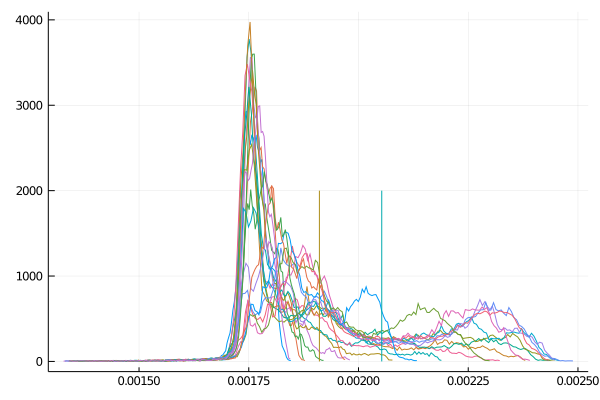

In [46]:
#img_gs = imfilter(cell_1[128:end-128,128:end-128, 13:14], Kernel.gaussian((2,2,1)))
plot(leg=false, lw=4)
yen = []
for i in 1:20
    img_gs = imfilter(cell_1[128:end-128,128:end-128, i], Kernel.gaussian((4,4)))
    edge, count = build_histogram( img_gs[img_gs.>0.001] )
    push!(yen, otsu_threshold(img_gs[img_gs .> 0.001]) )
    plot!(edge[100:end], count[100:end])
    #plot!([yen, yen],  [0, 6000])
end
yen_ = real(median(yen))
yen__ = real(maximum(yen))
plot!([yen_, yen_], [0, 2000])
plot!([yen__, yen__], [0 ,2000])

In [225]:
@time d16s1_1_nu, d16s1_1_th = extract3dnucleus(cell_1);
@time save(File(format"TIFF", "d16s1_1_otsu.ome.tiff"), N0f16.(d16s1_1_nu));
embedxml(512, 512, 20, 138, "d16s1_1_otsu.ome.tiff")

Extracting nucleus
 37.650326 seconds (4.02 M allocations: 36.460 GiB, 73.15% gc time)
177.210212 seconds (71 allocations: 4.043 GiB, 1.10% gc time)
Embedding OME-XML


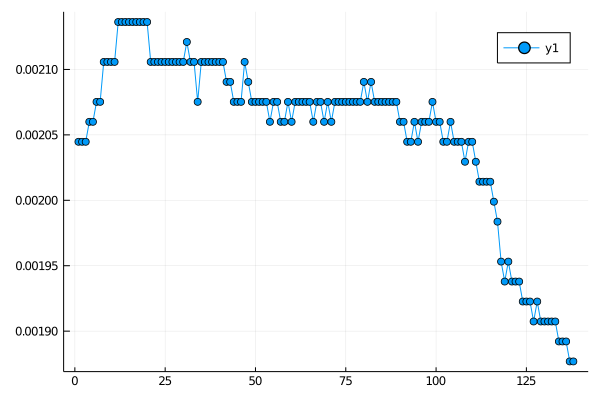

In [163]:
plot(d16s1_1_th, marker=:circle)

In [227]:
@time d16s1_2_nu, d16s1_2_th = extract3dnucleus(cell_2);
@time save(File(format"TIFF", "d16s1_2_otsu.ome.tiff"), N0f16.(d16s1_2_nu));
embedxml(512, 512, 20, 138, "d16s1_2_otsu.ome.tiff")

Extracting nucleus
 49.514899 seconds (3.53 M allocations: 57.627 GiB, 73.79% gc time)
189.580781 seconds (71 allocations: 4.043 GiB, 0.01% gc time)
Embedding OME-XML


In [276]:
@time img_norm, para = normalize(d16s1_1_nu);

  8.957058 seconds (2.02 M allocations: 16.590 GiB, 41.09% gc time)


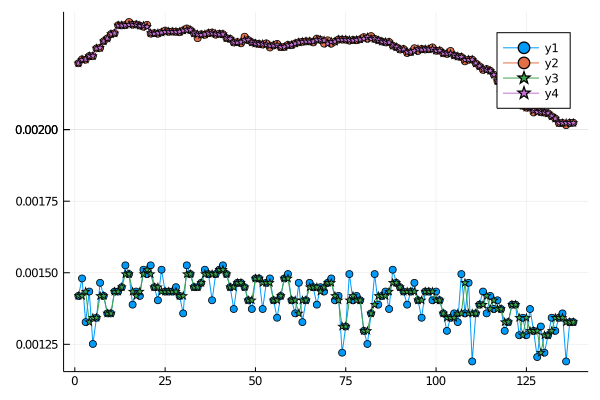

In [277]:
plot(para["low_line"], marker=:circle)
plot!(para["mean_line"], marker=:circle)
plot!(para["corrected_low_line"], marker=:star)
plot!(para["corrected_mean_line"], marker=:star)

In [284]:
function async_test()
save(File(format"TIFF", "d16s1_1_otsu_norm.ome.tiff"), N0f16.(img_norm));
embedxml(512, 512, 20, 138, "d16s1_1_otsu_norm.ome.tiff")
end

async_test (generic function with 1 method)

In [285]:
@async async_test()

Embedding OME-XML

Task (done) @0x00007f786df08280

In [289]:
ENV["JULIA_EDITOR"]

KeyError: KeyError: key "JULIA_EDITOR" not found